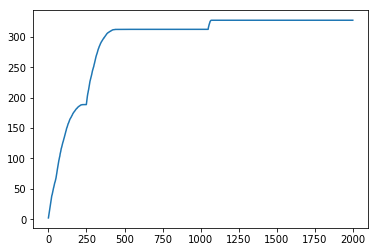

[]

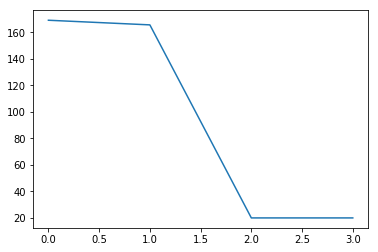

In [4]:
#Adaptive setting: Our epoch based algorithm
import numpy as np;
import numpy.random as ra;
import scipy.linalg as sla;
import numpy.linalg as la;
import pdb;
import scipy.io as sio
import matplotlib.pyplot as plt


#parameters
epoch_num = 4
num_trials = 10
N_epoch = 50 # Length of the first epoch
N = int(N_epoch * (((4** epoch_num) - 1)/3))  # Horizon/number of observations

trial_reg = np.zeros(N)
trial_estdim = np.zeros(epoch_num)


for trial in range(num_trials):



    N_epoch = 50 # Length of the first epoch
    sparse = 20
    
    N = int(N_epoch * (((4** epoch_num) - 1)/3))  # Horizon/number of observations
    d = 200   # number of covariates
    n_a = 25  # number of arms/actions
    S = 1   # norm of theta_star, b in our algorithm
    R = 0.01;
    S_hat = S # initial norm estimate of theta_star
    

    ridge = 0.01;
    delta = 0.006;
    epsilon = 0.006


    #- generate theta_star
    v = np.zeros(d)
    v[[*range(0,sparse)]] = ra.normal(0,1,sparse)
    v /= la.norm(v)
    theta_star_true = v * S;




#     # Pure exploration
#     X_p = ra.normal(0,1,(n_a,d));
#     reward_p = bias + np.dot(X_p, theta_star) + R * ra.normal(0,1,n_a);
#     times = np.ones(n_a);
#     avg_reward = reward_p



    
    my_c = .1 # Agressiveness (inv)
    

    sum_val = 0

    def ofulplus(d_est, N_epoch, delta, coor_est, sum_val):

        X = ra.normal(0,1,(N_epoch, n_a, d_est)) #- generate X
        # Regret
        cum_reg = np.zeros(N_epoch)
        
        theta_star = theta_star_true[coor_est]
        
        #- save expected rewards
        expt_reward = np.dot(X, theta_star);
        best_arm_vec = np.argmax(expt_reward, axis = 1)
        
        # Initial values
        XTy = np.zeros(d_est)
        invVt = np.eye(d_est) / ridge
        #X_invVt_norm_sq = np.sum(X * X, axis=1) / ridge;
        logdetV = d_est * np.log(ridge);
        sqrt_beta =  R * np.sqrt( logdetV - d_est * np.log(ridge) + np.log(1/(delta**2)) ) + np.sqrt(ridge) * S_hat
        theta_hat = np.zeros(d_est);
        Vt = ridge * np.eye(d_est); 



        for t in range(N_epoch):

        #For t = 0 choose randomly

            x = X[t]
            best_arm = best_arm_vec[t]
            X_invVt_norm_sq = np.sum(np.dot(x, invVt) * x, 1)
            obj_func = np.dot(x, theta_hat)  + my_c * sqrt_beta * np.sqrt(X_invVt_norm_sq) 
            pulled_idx = np.argmax(obj_func);  # Pull the arm with the highest estimated value
            #pulled_idx = np.random.randint(0, n_a)  # Pull a random arm

            xt = x[pulled_idx, :]
            reward = np.dot(xt, theta_star) + R * ra.normal(0,1)

            reg = np.dot(x[best_arm,:],theta_star) - np.dot(xt, theta_star)
            sum_val = sum_val + reg

            cum_reg[t] = sum_val

            XTy += reward * xt
            Vt += np.outer(xt, xt);

            tempval1 = np.dot(invVt, xt)    # d by 1, O(d^2)
            tempval2 = np.dot(tempval1, xt)      # scalar, O(d)
            logdetV += np.log(1 + tempval2);

            if (t % 5000 == 0):
                invVt = la.inv(Vt);
        #		X_invVt_norm_sq -= (np.dot(x, tempval1) ** 2) / (1 + tempval2) # efficient update, O(Nd)
            else:
                invVt -= np.outer(tempval1, tempval1) / (1 + tempval2) 
        #       X_invVt_norm_sq -= (np.dot(x, tempval1) ** 2) / (1 + tempval2) # efficient update, O(Nd)

            theta_hat = np.dot(invVt, XTy)
            #print(theta_hat)

            sqrt_beta = R * np.sqrt( logdetV - d_est * np.log(ridge) + np.log(1/(delta**2)) ) + np.sqrt(ridge) * S_hat


        return  cum_reg, sum_val






    tot_reg = []
    est_dim = []
    d_est = d
    coor_est = [*range(0,d)]
    pure_explore_coefficient = 1
    
    for i in range(epoch_num):
        cum_reg, sum_val = ofulplus(d_est, N_epoch, delta, coor_est, sum_val)
        
        X_pure = ra.normal(0,1,(int(pure_explore_coefficient * N_epoch), d))
        Y_pure = np.dot(X_pure,theta_star_true) + R* ra.normal(0,1,int(pure_explore_coefficient * N_epoch))
        theta_pure = np.dot(la.pinv(X_pure),Y_pure)
        
        
        my_list = []
        for r in range(d):
            if (np.abs(theta_pure[r]) > epsilon):
                my_list.append(r)

        coor_est = my_list
        d_est = len(coor_est)
        N_epoch = 4*N_epoch
        delta = delta/2
        epsilon = epsilon/2
    
        tot_reg = np.concatenate((tot_reg,cum_reg), axis=None)
        est_dim.append(len(coor_est))

    trial_reg = trial_reg + tot_reg 
    trial_estdim = trial_estdim + est_dim


avg_trial_reg = trial_reg/num_trials
avg_estdim = trial_estdim/num_trials

plt.plot(avg_trial_reg[[*range(0,2000)]])
#plt.plot(avg_trial_reg)
plt.show()  

plt.plot(avg_estdim)
plt.plot()

In [5]:
min(theta_star_true)

-0.5462073537570743

In [52]:
import scipy.io as sio
import numpy as np

fname1='dim_ada_ep_5_reg_20_200'

my_a={}
my_a['reg']=np.array(avg_trial_reg)
sio.savemat(fname1,my_a)

fname2 = 'dim_ada_ep_5_dim_20_200'
my_b={}
my_b['reg']=np.array(avg_estdim)
sio.savemat(fname2,my_b)

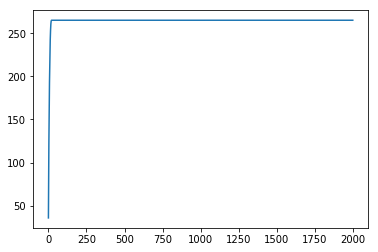

In [4]:
# Non-adaptive setting: Basically OFUL algorithm
import numpy as np;
import numpy.random as ra;
import scipy.linalg as sla;
import numpy.linalg as la;
import pdb;
import matplotlib.pyplot as plt
#import emd

#parameters
num_trials = 15
N = 2000
trial_reg = np.zeros(N)

for trial in range(num_trials):

    N = 2000  # Horizon/number of observations
    d = 20   # number of covariates
    n_a = 75  # number of arms/actions
    S = 15   # norm of theta_star, b in our algorithm
    R = 0.01;
    sparse = 20
    
    ridge = 0.01;
    delta = 0.002;
    S_hat = S; # upper bound on the norm of theta_star

     #- generate theta_star
    v = np.zeros(d)
    v[[*range(0,sparse)]] = ra.normal(0,1,sparse)
    v /= la.norm(v)
    theta_star = v * S;

        #- generate X
    X = ra.normal(0,1,(N, n_a, d));
    #norms = la.norm(X);
    #X /= norms.reshape(-1,1)
    #X = X;
   



    #- save expected rewards
    expt_reward =  np.dot(X, theta_star);
    best_arm_vec = np.argmax(expt_reward, axis = 1);


    def calc_sqrt_beta_det2(d,t,R,ridge,delta,S_hat,logdetV):
      return R * np.sqrt( logdetV - d * np.log(ridge) + np.log(1/(delta**2)) ) + np.sqrt(ridge) * S_hat

    
    t = 1;

    XTy = np.zeros(d)
    invVt = np.eye(d) / ridge
    #X_invVt_norm_sq = np.sum(X * X, axis=1) / ridge;
    logdetV = d * np.log(ridge);
    sqrt_beta = calc_sqrt_beta_det2(d,t,R,ridge,delta,S_hat,logdetV);      
    theta_hat = np.zeros(d);
    Vt = ridge * np.eye(d); 
    my_c = .1 # Agressiveness (inv)

    # Regret
    cum_reg = np.zeros(N)
    sum_val = 0

    for t in range(N):

    #For t = 0 choose randomly

        x = X[t]
        best_arm = best_arm_vec[t]
    #	X_invVt_norm_sq = np.sum(x * x, axis=1) / ridge;
        X_invVt_norm_sq = np.sum(np.dot(x, invVt) * x, 1)
        obj_func =  np.dot(x, theta_hat)  + my_c * sqrt_beta * np.sqrt(X_invVt_norm_sq) 
        pulled_idx = np.argmax(obj_func);  # Pull the arm with the highest estimated value
        #pulled_idx = np.random.randint(0, n_a)  # Pull a random arm

        xt = x[pulled_idx, :]
        reward =  np.dot(xt, theta_star) + R * ra.normal(0,1)

        reg =  np.dot(x[best_arm,:],theta_star) - np.dot(xt, theta_star)
        sum_val = sum_val + reg

        cum_reg[t] = sum_val

        XTy += reward * xt
        Vt += np.outer(xt, xt);

        tempval1 = np.dot(invVt, xt)    # d by 1, O(d^2)
        tempval2 = np.dot(tempval1, xt)      # scalar, O(d)
        logdetV += np.log(1 + tempval2);

        if (t % 200 == 0):
            invVt = la.inv(Vt);
    #		X_invVt_norm_sq -= (np.dot(x, tempval1) ** 2) / (1 + tempval2) # efficient update, O(Nd)
        else:
            invVt -= np.outer(tempval1, tempval1) / (1 + tempval2) 
    #       X_invVt_norm_sq -= (np.dot(x, tempval1) ** 2) / (1 + tempval2) # efficient update, O(Nd)

        theta_hat = np.dot(invVt, XTy)
        #print(theta_hat)
        my_t = t + 1

        sqrt_beta = calc_sqrt_beta_det2(d, my_t, R, ridge, delta, S_hat, logdetV);
        
    trial_reg = trial_reg + cum_reg
    


avg_trial_reg = trial_reg/num_trials

plt.plot(avg_trial_reg)
plt.show()  

In [54]:
import scipy.io as sio
import numpy as np

fname1='OFUL_20_200_reg'

my_c={}
my_c['reg']=np.array(avg_trial_reg)
sio.savemat(fname1,my_c)